In [66]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

In [1]:
#Configuring the IO structure:
W_size=3
st=4
et=22
Bin_size=1
prediction_size=1
n_features=282
irows=int(W_size/Bin_size)
icols=n_features
orows=int(prediction_size/Bin_size)
ocols=147
nipd=int((et-st)/Bin_size)-irows-orows+1

In [2]:
# Data Preparation
import pandas as pd

# Selecting data based on bin size
if Bin_size==0.5:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_30min_normed.csv',header =None)
if Bin_size==1:
    df2 = pd.read_csv('/home/pennyworth/Documents/Bus/Data/from_R_19B_1Hr_normed.csv',header =None)
    
#Converting dataframe into matrix    
dataset=df2.as_matrix()

/home/pennyworth/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [3]:
#Checking if the import is good to go:
if len(dataset)-1==34*18/Bin_size:
    print("Import successful!")

Import successful!


In [4]:
print(irows,orows)
dataset[700:714]

3 1


array([], shape=(0, 282), dtype=float64)

In [5]:
# multivariate multi-step data preparation
import numpy as np
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

#Split a multivariate sequence into samples and put them into X and y
X, y = list(), list()
def split_sequences(sequences, n_steps_in, n_steps_out):
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :-2]
		X.append(seq_x)
		y.append(seq_y)
	return None

n_steps_in, n_steps_out = int(irows), int(orows)
rows_pday=int((et-st)/Bin_size)

# convert into input/output
# Need to change to 34 or 35 or whatever when nrows in dataset change
for i in range(1,35):
    todays_df=dataset[(i-1)*rows_pday+1:i*rows_pday+1]
    split_sequences(todays_df, n_steps_in, n_steps_out)


#Check if the io sample count is valid:
if len(X[1][1])==n_features and nipd*34==len(X)==len(y) and len(y[1][0])==280:
        print("IO Matrix creation successful!")
else:
    print("IO Matrix creation unsuccessful!",len(X[1][1])==n_features,nipd*34==len(X)==len(y),len(y[1][0])==280)

Using TensorFlow backend.


IO Matrix creation successful!


In [6]:
#Filtering the Na IO matrices out
from math import isnan
import numpy as np
X_fil=np.array(X)
y_fil=np.array(y)
del_index=[]

# Noting down the index of Na matricesin del_index 
for i in range(len(X_fil)):
    del_index.append(np.any(np.isnan(X_fil[i])) or np.any(np.isnan(y_fil[i])))

# Filtering out the Na matrices from y_fil and X_fil by indexing using a list
y_fil=y_fil[list(~np.array(del_index))]
X_fil=X_fil[list(~np.array(del_index))]

# Check if the filtering is successful:
Na_count=0
for i in range(len(X_fil)):
    if np.any(np.isnan(y_fil[i]))==True & np.any(np.isnan(X_fil[i]))==True:
        Na_count=Na_count+1
if Na_count==0:
    print("Na Matrices filtered out sucessfuly!")
# y=np.array(y)
# for el in y[list(~np.array(deathlist))]:
#     print(np.any(np.isnan(Xtrial[i])))


Na Matrices filtered out sucessfuly!


In [7]:
# Print number of IO Pairs available:
print(len(y_fil)," I/O pairs available.")

289  I/O pairs available.


In [8]:
# Flatten output
n_output = y_fil.shape[1] * y_fil.shape[2]
y_fil = y_fil.reshape((y_fil.shape[0], n_output))

In [9]:
# Check the number of features
if n_features == X_fil.shape[2]:
    print("Good to go!")

Good to go!


In [10]:
# Splitting into train and test sets
np.random.seed(95)
msk = np.random.rand(len(X_fil)) < 0.9
X_train = X_fil[msk]
y_train = y_fil[msk]
X_test = X_fil[~msk]
y_test = y_fil[~msk]
print("Dataset splitting done!")

Dataset splitting done!


In [11]:
# multivariate output multi-step 1d cnn example
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(irows, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(n_output))
model.compile(optimizer='adam', loss=['mse'],metrics=["mape"])
epochno=12
# fit model
history=model.fit(X_train, y_train, epochs=epochno, verbose=0, validation_data = (X_test, y_test))
print("Number or epochs:",epochno)
print("Number of input features:",n_features)
print("Number of output features:",n_output)
print("Bin size:",Bin_size)
print("Window size:",W_size)
print("Number of I/O pairs available:",len(y_fil))
print("Model Mape loss:",model.evaluate(X_test,y_test)[1])
print("Model MSE loss (Minimized):",model.evaluate(X_test,y_test)[0])
print("RMSE loss:",np.sqrt(model.evaluate(X_test,y_test)[0]))

# Demonstrate Prediction
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
# x_input = x_input.reshape((1, n_steps_in, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

W0710 19:33:42.714025 139915103536960 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 19:33:42.725475 139915103536960 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 19:33:42.737399 139915103536960 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 19:33:42.802294 139915103536960 deprecation_wrapper.py:119] From /home/pennyworth/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W07

Number or epochs: 12
Number of input features: 282
Number of output features: 280
Bin size: 1
Window size: 3
Number of I/O pairs available: 289
34/34 [==============================] - 0s 87us/step
Model Mape loss: 1385.225217033835
34/34 [==============================] - 0s 104us/step
Model MSE loss (Minimized): 0.0030858069384361014
34/34 [==============================] - 0s 89us/step
RMSE loss: 0.05555003994990554


dict_keys(['val_loss', 'val_mean_absolute_percentage_error', 'loss', 'mean_absolute_percentage_error'])


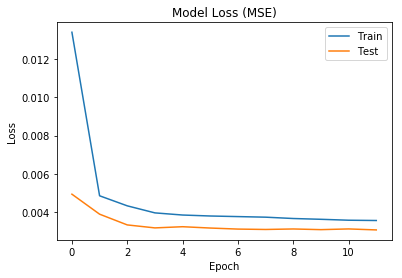

In [12]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#axes = plt.gca()
#axes.set_ylim([7500,0.2*100000])
#axes.set_xlim([1500,3000])
plt.show()

In [52]:
#history=model.fit(X, y, epochs=3000, verbose=1)
#model.evaluate(X,y)

In [53]:
# import random
# #from plotnine import *
# rn=random.randint(1,150)
# # demonstrate prediction
# x_input = X[rn]
# y_output = y[rn]
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=1)
# pdt=yhat[0]
# act=y_output
# print(len(pdt))
# print(len(act))
# #library(ggplot2)
# #ggplot(, aes(x = drat, y = mpg)) + geom_point()

In [19]:
# Plot a random Prediction vs actual travel time
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(82)
rnd=np.random.randint(len(X_test))
print(rnd)

# Demonstrate Prediction
x_input = X_test[rnd]
x_input = x_input.reshape((1, irows, n_features))
yhat = model.predict(x_input, verbose=0)
y_output = y_test[rnd]
#print(len(yhat[0]))
pdt=yhat[0]
act=y_output
if len(pdt)==len(act):
    print("Lengths match good to go!")

3
Lengths match good to go!


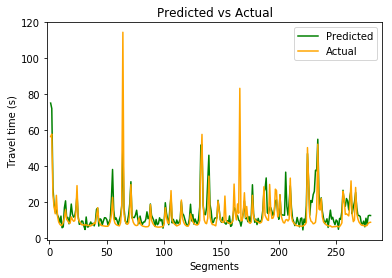

In [20]:
import matplotlib.pyplot as plt
import numpy

x=list(range(1,len(pdt)+1))
plt.plot(x, pdt[0:], color='g',label="Predicted")
plt.plot(x, act[0:], color='orange',label="Actual")
plt.xlabel('Segments')
plt.ylabel('Travel time (s)')
plt.title('Predicted vs Actual')
axes = plt.gca()
#axes.set_ylim([0,180])
axes.set_xlim([-2,len(pdt)+10])
leg = plt.legend();
plt.show()